# Capstone Project - The Battle of Neighborhoods

### Introduction

New York City, being the largest city in United States has a long history of immigration. The city is growing rapidly and accomodates large number of legal immigrants admitted into the United States.

It is a densly populated area by the immigrants, especially the Lower East Side. It also has great diveristy in languages, howeeve, English is the most widely spoken language.

Diversity in culture leads to diversity in food items and hence food restaurants. There are many resturants in New york City, each beloning to different categories like Chinese , Japanese , French etc.

The aim of this project is to list and visualize parts of New York City with some really good Japanese restaurants.

### Data 
For this project we need the following data :
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> Japanese resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Japanese resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Japanese Resturants.
- Find rating , tips and like count for each Japanese Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
- What is best location in New York City for Japanese Cuisine ? 
- Which areas have potential Japanese Resturant Market ? 
- Which all areas lack Japanese Resturants ?
- Which is the best place to stay if I prefer Japanese Cuisine ?

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [1]:
!pip install geocoder

     |████████████████████████████████| 102kB 1.2MB/s ta 0:00:01


In [2]:
!pip install folium

     |████████████████████████████████| 92kB 1.1MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium 
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [4]:
def geo_location(address):
   
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [5]:
def get_venues(lat,lng):
    
    
    radius=1000
    LIMIT=100
    CLIENT_ID = 'OX13HQ3GH2D4BAACDFXPF2CCBAQVFT0T5BCS3IB20SLJXBY0' 
    CLIENT_SECRET = 'SRV5VH1V04R4PKDWBF2WKPNK2WOTR2YOSL0AYEIV5KHYHWO5'
    VERSION = '20180605' 
    
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'OX13HQ3GH2D4BAACDFXPF2CCBAQVFT0T5BCS3IB20SLJXBY0' 
    CLIENT_SECRET = 'SRV5VH1V04R4PKDWBF2WKPNK2WOTR2YOSL0AYEIV5KHYHWO5'
    VERSION = '20180605' 
    
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    
    features=resp['features']
    
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [8]:
new_york_data=get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

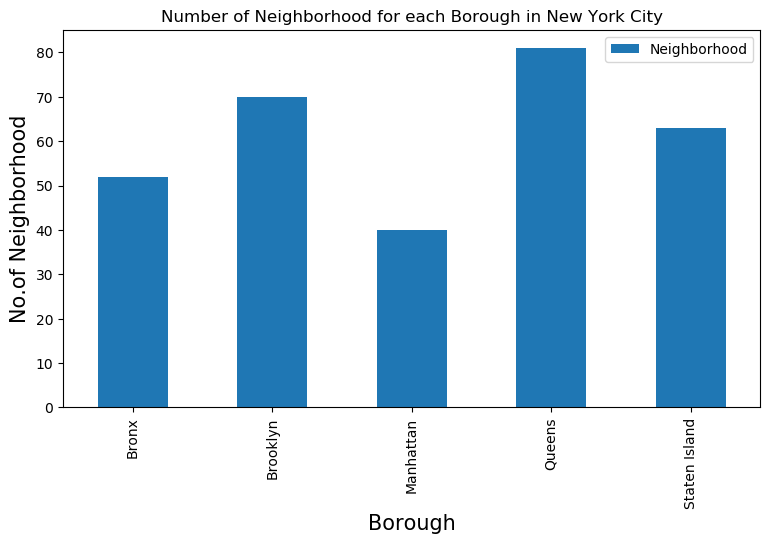

In [11]:
plt.figure(figsize=(9,5), dpi = 100)

plt.title('Number of Neighborhood for each Borough in New York City')

plt.xlabel('Borough', fontsize = 15)

plt.ylabel('No.of Neighborhood', fontsize=15)

new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')

plt.legend()

plt.show()

In [12]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1

for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
    

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

KeyError: 'groups'

Now that we have got all the japanese resturants in new york city , we will analyze it

In [13]:
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


In [14]:
japanese_rest_ny.shape

(139, 4)

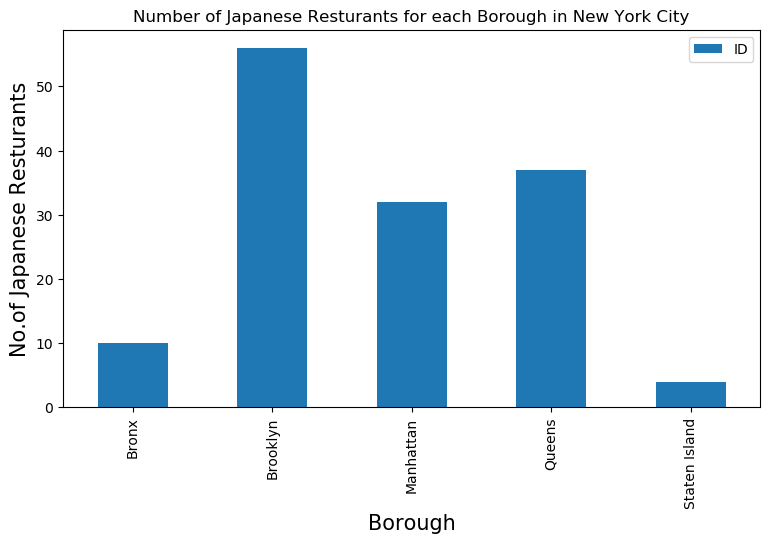

In [15]:
plt.figure(figsize=(9,5), dpi = 100)

plt.title('Number of Japanese Resturants for each Borough in New York City')

plt.xlabel('Borough', fontsize = 15)

plt.ylabel('No.of Japanese Resturants', fontsize=15)

japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')

plt.legend()

plt.show()

We see that Brooklyn has the largest number of japanese resturants

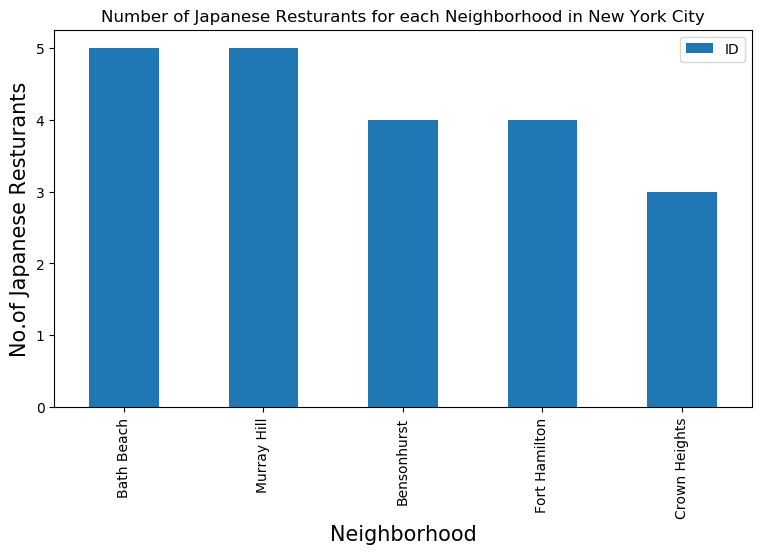

In [16]:
plt.figure(figsize=(9,5), dpi = 100)

plt.title('Number of Japanese Resturants for each Neighborhood in New York City')

plt.xlabel('Neighborhood', fontsize = 15)

plt.ylabel('No.of Japanese Resturants', fontsize=15)

japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')

plt.legend()

plt.show()

In [17]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Bath Beach']

,Borough,Neighborhood,ID,Name
39,Brooklyn,Bath Beach,4bad45c9f964a52089403be3,Chikurin
40,Brooklyn,Bath Beach,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
41,Brooklyn,Bath Beach,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
42,Brooklyn,Bath Beach,4c326b9fa0ced13ac126156e,Ichi Sushi
43,Brooklyn,Bath Beach,4b787863f964a52080d02ee3,Shiki Japanese Hibachi


Now we will get the ranking of each resturant for further analysis.

In [18]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in japanese_rest_ny.values.tolist():
    if count == 50:
        break
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     31     9.0    19
( 1 / 139 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.9    25
( 2 / 139 ) processed
                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     31     9.0    19
( 3 / 139 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.9    25
( 4 / 139 ) processed
                         ID                                         Name  \
0  4dbdf3d790a02849cbd675be  Ohana Japanese Habachi Seafood & Steakhouse   

   Likes  Rating  Tips  
0     33     7.6    18  
( 5 / 139 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8

In [19]:
japanese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,31,9.0,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.9,25
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,31,9.0,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.9,25
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,33,7.6,18


In [20]:
japanese_rest_stats_ny.shape

(49, 7)

In [21]:
japanese_rest_ny.shape

(139, 4)

So we got data for all resturants
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limit of 50 per day, we will refer to saved data sheet csv if required

In [22]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [23]:
japanese_rest_stats_ny_csv=pd.read_csv('japanese_rest_stats_ny.csv')

In [24]:
japanese_rest_stats_ny_csv.shape

(49, 7)

In [25]:
japanese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,31,9.0,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.9,25
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,31,9.0,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.9,25
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,33,7.6,18


In [26]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
Borough         49 non-null object
Neighborhood    49 non-null object
ID              49 non-null object
Name            49 non-null object
Likes           49 non-null object
Rating          49 non-null float64
Tips            49 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [27]:
japanese_rest_stats_ny['Likes']=japanese_rest_stats_ny['Likes'].astype('float64')

In [28]:
japanese_rest_stats_ny['Tips']=japanese_rest_stats_ny['Tips'].astype('float64')

In [29]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
Borough         49 non-null object
Neighborhood    49 non-null object
ID              49 non-null object
Name            49 non-null object
Likes           49 non-null float64
Rating          49 non-null float64
Tips            49 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


Now the data types looks correct

In [30]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                884
Rating                               9.1
Tips                                 242
Name: 27, dtype: object

In [31]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood            Brooklyn Heights
ID              48a41073f964a52091511fe3
Name                              Hibino
Likes                                464
Rating                               9.2
Tips                                 155
Name: 31, dtype: object

In [32]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                884
Rating                               9.1
Tips                                 242
Name: 27, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [33]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [34]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
25,Spuyten Duyvil,8.950000
22,Riverdale,8.950000
16,Kingsbridge,8.950000
21,Prospect Heights,8.900000
4,Brooklyn Heights,8.850000
13,Fort Greene,8.800000
8,Clinton Hill,8.700000
26,Williamsburg,8.650000
9,Cobble Hill,8.600000
20,Park Slope,8.566667


Above are the top neighborhoods with top average rating of Japanese resturants

In [35]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [36]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,7.80
0,Bronx,6.86


Similarly these are the average rating of Japanese Resturants for each Borough

Lets visualize it

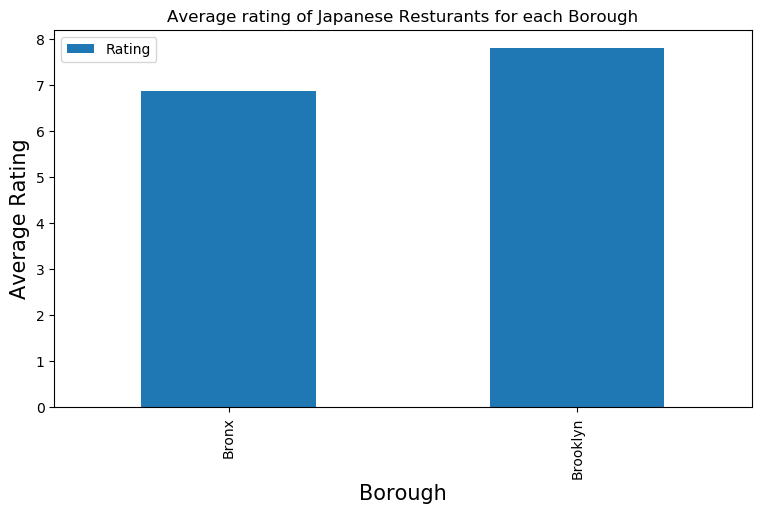

In [37]:
plt.figure(figsize=(9,5), dpi = 100)

plt.title('Average rating of Japanese Resturants for each Borough')

plt.xlabel('Borough', fontsize = 15)

plt.ylabel('Average Rating', fontsize=15)

japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')

plt.legend()

plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [39]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bath Beach,7.080000
1,Bay Ridge,7.900000
2,Bedford Stuyvesant,7.500000
3,Bensonhurst,7.050000
4,Brooklyn Heights,8.850000
5,Bushwick,8.300000
6,Castle Hill,7.300000
7,City Island,7.600000
8,Clinton Hill,8.700000
9,Cobble Hill,8.600000


We will join this dataset to original new york data to get lonitude and latitude

In [40]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [42]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bath Beach,40.599519,-73.998752,7.080000
1,Brooklyn,Bay Ridge,40.625801,-74.030621,7.900000
2,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,7.500000
3,Brooklyn,Bensonhurst,40.611009,-73.995180,7.050000
4,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.850000
5,Brooklyn,Bushwick,40.698116,-73.925258,8.300000
6,Bronx,Castle Hill,40.819014,-73.848027,7.300000
7,Bronx,City Island,40.847247,-73.786488,7.600000
8,Brooklyn,Clinton Hill,40.693229,-73.967843,8.700000
9,Brooklyn,Cobble Hill,40.687920,-73.998561,8.600000


Now we will show this data on a map

In [43]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [44]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose

In [45]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [46]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        

ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
<br>Lets Visualize Boroughs based on average Rating

### Conclusion 
- Best neighborhoods for Japanese cuisine can be observed easily. 
- Manhattan have potential japanese Resturant Market/ 
- Staten Island	ranks last in average rating of japanese Resturants.
- Manhattan is the best place to stay if you prefer japanese Cuisine.

### Limitations 
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare
- Could not do analysis of rating, tips and likes on more than 50 neighbours. These are premium calls for FourSquare and can be made only 50/day.